In [1]:
import pandas as pd
import numpy as np
import sklearn
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib
import os, random
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
from omnixai.visualization.dashboard import Dashboard

# Load and preprocess data

In [2]:
# Load dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

# df = pd.read_csv('../adult/adult.data', names=columns,na_values=' ?')
df = pd.DataFrame(
    np.genfromtxt('../adult/adult.data', delimiter=', ', dtype=str),
    columns=columns
)

df.replace(['?'], np.nan, inplace=True)
df.dropna(inplace=True)

# Declare categorical columns
categorical_columns = [
    "workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income"
]

for feature in columns:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        print(feature)
        df[feature] = df[feature].astype("int")

#create bins for hours per week
# df["hours_per_week"] = pd.cut(
#     x=df["hours_per_week"],
#     bins=[0.9, 25, 39, 40, 55, 100],
#     labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"]
# )

df['income'] = df['income'].apply(lambda x:x.strip())
df['income'] = df['income'].apply(lambda x: 1 if x=='>50K' else 0)
df['age'] = df['age'].apply(lambda x: "Senior" if x>25 else "Young")
df['age_cat'] = df['age'].apply(lambda x: 1 if x == "Senior" else 0)
df['sex_cat'] = df['sex'].apply(lambda x: 1 if x == " Male" else 0)
df['age_cat_private'] = df['age_cat']
df['sex_cat_private'] = df['sex_cat']
df["relationship"] = df["relationship"].replace('Husband','Married')
df["relationship"] = df["relationship"].replace('Wife','Married')

age
fnlwgt
education_num
capital_gain
capital_loss
hours_per_week


/var/folders/2l/srpzk4jx3bd_85xnzblspysc0000gn/T/ipykernel_7858/2867744666.py:43: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

/var/folders/2l/srpzk4jx3bd_85xnzblspysc0000gn/T/ipykernel_7858/2867744666.py:44: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [3]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat,sex_cat,age_cat_private,sex_cat_private
0,Senior,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1,0,1,0
1,Senior,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,13,United-States,0,1,0,1,0
2,Senior,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1,0,1,0
3,Senior,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0,1,0,1,0
4,Senior,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,40,Cuba,0,1,0,1,0


In [4]:
df.shape

(30162, 19)

# Create private data

In [5]:
def get_p_q(epsilon):
    p = np.exp(epsilon)/(1+np.exp(epsilon))
    return p, p

def rand_resp(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    toss = np.random.random()
    if x == 0:
        y = 0 if toss <= p else 1
    else:
        y = 1 if toss <= p else 0
    return y

def apply_ldp(data, sensitive_columns, epsilon):
    print(f"Applying LDP with epsilon = {epsilon}")
    private_data = data.copy()

    for col in sensitive_columns:
        private_data[f"{col}_private"] = private_data[col].apply(lambda x: rand_resp(x,epsilon))

    return private_data

In [6]:
sensitive_attributes = ['age_cat','sex_cat']
epsilon = 0.5
df_private = apply_ldp(df, sensitive_attributes, epsilon)

Applying LDP with epsilon = 0.5


In [7]:
df_private.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat,sex_cat,age_cat_private,sex_cat_private
0,Senior,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1,0,1,0
1,Senior,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,13,United-States,0,1,0,1,1
2,Senior,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1,0,1,0
3,Senior,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0,1,0,0,0
4,Senior,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,40,Cuba,0,1,0,0,0


In [8]:
df_private.shape

(30162, 19)

In [9]:
# os.makedirs('../data', exist_ok=True)
# df_private.to_csv('../data/private_data.csv')

# Split private data

In [10]:
# X = df_private.drop(columns=['age', 'sex', 'age_cat', 'sex_cat', 'income'], axis=1)
# y = df_private['income']
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train_data = X_train_val.copy()
# train_data['income'] = y_train_val
# test_data = X_test.copy()
# test_data['income'] = y_test
# train_data = train_data.dropna().reset_index(drop=True)
# test_data = test_data.dropna().reset_index(drop=True)

# print(f'Train data: {train_data.shape}')
# print(f'Test data: {test_data.shape}')

# Split private data and train the private classifier

In [11]:
df_priv = df_private.drop(columns=['age', 'sex', 'age_cat', 'sex_cat'], axis=1)
private_tabular = Tabular(
    df_priv,
    categorical_columns=['workclass', 'education', 'marital_status', 'occupation',
                         'relationship', 'race', 'native_country', 'age_cat_private'],
    target_column='income'
)

df_priv.head(2)

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat_private,sex_cat_private
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,40,United-States,0,1,0
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,0,0,13,United-States,0,1,1


In [12]:
print(private_tabular.data.shape)
private_tabular.data.head(2)

(30162, 15)


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat_private,sex_cat_private
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,40,United-States,0,1,0
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,0,0,13,United-States,0,1,1


In [13]:
transformer = TabularTransform().fit(private_tabular)
class_names = transformer.class_names
X = transformer.transform(private_tabular)

In [14]:
x = X[:, :-1]
y = X[:, -1]
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

test_labels = test_labels.astype(int)

print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

Training data shape: (24129, 103)
Test data shape:     (6033, 103)


In [15]:
model = LGBMClassifier(objective="binary", verbose=-1)
model.fit(train, train_labels)

predict_function: lambda z: model.predict_proba(transformer.transform(z))

In [16]:
train_tabular = transformer.invert(train)
test_tabular = transformer.invert(test)

In [17]:
test_df = test_tabular.to_pd()
test_df['income'] = test_labels
predictions = model.predict(test)
predictions = predictions.astype(int)
test_df['prediction'] = predictions

test_df.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,income,prediction
0,Private,162034.0,Bachelors,13.0,Married-civ-spouse,Sales,Married,White,0.0,0.0,70.0,United-States,0,0.0,0,1
1,Private,245661.0,HS-grad,9.0,Separated,Machine-op-inspct,Own-child,White,0.0,0.0,40.0,United-States,1,0.0,0,0
2,Private,402998.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Married,White,0.0,0.0,58.0,United-States,1,0.0,1,1
3,Private,142383.0,Assoc-acdm,12.0,Never-married,Sales,Not-in-family,Other,0.0,0.0,36.0,United-States,0,0.0,0,0
4,Private,211032.0,Preschool,1.0,Married-civ-spouse,Farming-fishing,Other-relative,White,41310.0,0.0,24.0,Mexico,1,0.0,0,1


Test: accuracy=0.8611
Test: TP=934, TN=4261, FP=270, FN=568


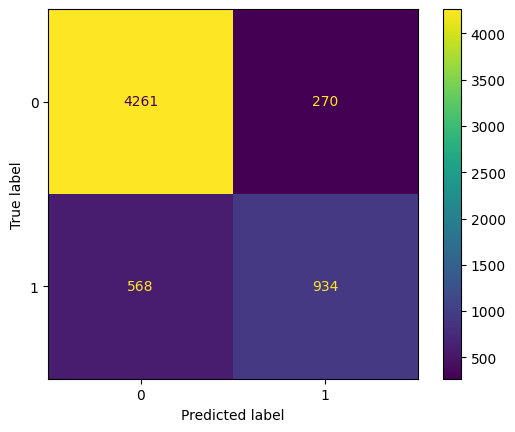

In [18]:
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(f'Test: {accuracy=:.4f}')

cm = sklearn.metrics.confusion_matrix(test_labels, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot();

In [19]:
# os.makedirs('../model/lgbm_explainability', exist_ok=True)
# epsilon_value = 0.5
# joblib.dump(transformer,f"../model/lgbm_explainability/preprocessing_explainability_{epsilon_value}.pkl")
# joblib.dump(model,f"../model/lgbm_explainability/lgbm_explainability_{epsilon_value}.pkl")

# Explainability on private data

## Global explainability

In [20]:
train_tabular.data.head(2)

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private
0,Private,198870.0,Bachelors,13.0,Never-married,Adm-clerical,Own-child,Black,0.0,0.0,35.0,United-States,0,1.0
1,Federal-gov,119832.0,Some-college,10.0,Married-civ-spouse,Adm-clerical,Married,White,7298.0,0.0,40.0,United-States,1,0.0


In [21]:
train_tabular.data.shape

(24129, 14)

In [22]:
explainers_global = TabularExplainer(
    explainers=["ale", "shap_global"],                      # The explainers to apply
    mode="classification",                                  # The task type
    data=train_tabular,                                        # The data for initializing the explainers
    model=model,                                   # The ML model to explain
    preprocess=lambda z: transformer.transform(z),   # Converts raw features into the model inputs
)

In [23]:
global_explanations = explainers_global.explain_global()

/Users/ngochoang/miniforge3/envs/omnixai/lib/python3.11/site-packages/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1486927826107165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/Users/ngochoang/miniforge3/envs/omnixai/lib/python3.11/site-packages/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19160760675032576' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/Users/ngochoang/miniforge3/envs/omnixai/lib/python3.11/site-packages/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09852060938481397' has dtype incompat

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
print("ALE results:")
global_explanations["ale"].ipython_plot(class_names=transformer.class_names)

ALE results:


In [25]:
print("SHAP results:")
global_explanations["shap_global"].ipython_plot(class_names=transformer.class_names, max_display=14)

SHAP results:


In [26]:
exp = global_explanations['shap_global'].get_explanations()
exp

{'features': ['education', 'workclass'],
 'scores': [0.2319410723140718, 0.23194107231407138]}

In [27]:
ale_dict = global_explanations["ale"].get_explanations()
ale_dict.keys()

odict_keys(['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'native_country', 'age_cat_private', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'sex_cat_private'])

## Local explainability

In [28]:
train_tabular.data.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private
0,Private,198870.0,Bachelors,13.0,Never-married,Adm-clerical,Own-child,Black,0.0,0.0,35.0,United-States,0,1.0
1,Federal-gov,119832.0,Some-college,10.0,Married-civ-spouse,Adm-clerical,Married,White,7298.0,0.0,40.0,United-States,1,0.0
2,Private,122272.0,Bachelors,13.0,Never-married,Adm-clerical,Own-child,White,0.0,0.0,30.0,United-States,1,1.0
3,Private,87507.0,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Married,Asian-Pac-Islander,0.0,0.0,60.0,India,0,1.0
4,Private,245302.0,Some-college,10.0,Divorced,Sales,Own-child,Black,0.0,0.0,40.0,United-States,0,0.0


In [37]:
explainers_local = TabularExplainer(
    explainers=['lime', 'mace'],                       # The explainers to apply
    mode="classification",                             # The task type
    data=train_tabular,                                   # The data for initializing the explainers
    model=model,                               # The ML model to explain
    preprocess=lambda z: transformer.transform(z),  # Converts raw features into the model inputs
    params={
        "mace": {"ignored_features": ["sex_cat_private", "race"]}  # params which cannot change when creating counterfactuals
    }
)


In [38]:
instance_ids = random.choices(list(test_tabular.data.index), k=5)
print(f'Randomized instance ids: {instance_ids}')
test_instances = test_tabular[instance_ids]
local_explanations = explainers_local.explain(X=test_instances)

Randomized instance ids: [4703, 1340, 456, 4412, 517]


In [39]:
print("LIME results:")
for i, instance_id in enumerate(instance_ids):
    print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {model.predict(test[instance_id:instance_id+1])}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
    local_explanations["lime"].ipython_plot(index=i, class_names=transformer.class_names)

LIME results:
Instance 4703 has label 0 and prediction [0.], with probs [0.98805979 0.01194021]


Instance 1340 has label 0 and prediction [0.], with probs [0.67365339 0.32634661]


Instance 456 has label 1 and prediction [1.], with probs [0.04773758 0.95226242]


Instance 4412 has label 0 and prediction [0.], with probs [0.97918176 0.02081824]


Instance 517 has label 0 and prediction [0.], with probs [0.55754756 0.44245244]


In [40]:
# print("LIME results:")
# for i, instance_id in enumerate(instance_ids):
#     print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {model.predict(test[instance_id:instance_id+1])}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
#     local_explanations["lime"].ipython_plot(index=i, class_names=transformer.class_names)

print("SHAP results:")
for i, instance_id in enumerate(instance_ids):
    print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {model.predict(test[instance_id:instance_id+1])}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
    local_explanations["shap"].ipython_plot(index=i, class_names=transformer.class_names)

SHAP results:
Instance 4703 has label 0 and prediction [0.], with probs [0.98805979 0.01194021]


KeyError: 'shap'

## Counterfactual explanations

In [34]:
print("MACE results:")


for expl_id, instance_id in enumerate(instance_ids):
    
    query_df = local_explanations['mace'].get_explanations()[expl_id]['query'].reset_index(drop=True)
    query_df.index = [f"{instance_id}"] * len(query_df)
    # display(query_df)


    counter_df = local_explanations['mace'].get_explanations()[expl_id]['counterfactual'].reset_index(drop=True)
    counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]
    # display(counter_df)

    combined_df = pd.concat([query_df, counter_df])


    # Highlighting function
    def highlight_changes(row):
        instance_row = combined_df.iloc[0]  # Reference row for the instance
        return ["color: red" if row[col] != instance_row[col] else "" for col in combined_df.columns]

    # Apply the style
    styled_df = combined_df.style.apply(highlight_changes, axis=1)
    
    # Display the styled dataframe
    display(styled_df) 



MACE results:


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
2224,Private,427965.000000,Bachelors,13.000000,Never-married,Adm-clerical,Not-in-family,Black,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 2224,Private,427965.000000,Bachelors,14.687500,Married-civ-spouse,Adm-clerical,Not-in-family,Black,0.000000,0.000000,43.750000,United-States,1,0.000000,1
CF[1] for 2224,Private,427965.000000,Bachelors,13.000000,Married-civ-spouse,Adm-clerical,Married,Black,0.000000,0.000000,40.312500,United-States,1,0.000000,1
CF[2] for 2224,Private,427965.000000,Bachelors,13.062500,Married-civ-spouse,Adm-clerical,Married,Black,0.000000,0.000000,40.312500,United-States,1,0.000000,1
CF[3] for 2224,Local-gov,417521.437500,Masters,13.000000,Never-married,Exec-managerial,Married,Black,4787.000000,120.750000,40.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
2543,Private,288983.000000,Some-college,10.000000,Never-married,Protective-serv,Not-in-family,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 2543,Private,288983.000000,Some-college,10.000000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[1] for 2543,Private,288440.625000,Some-college,10.000000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[2] for 2543,Private,288983.000000,Some-college,10.000000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,39.875000,United-States,1,0.000000,1
CF[3] for 2543,Private,288983.000000,Some-college,9.937500,Never-married,Protective-serv,Not-in-family,White,7207.500000,0.000000,40.000000,United-States,1,0.000000,1
CF[4] for 2543,Local-gov,288440.625000,Some-college,9.937500,Never-married,Protective-serv,Not-in-family,White,12499.875000,0.000000,39.875000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
5387,Private,274528.000000,Some-college,10.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,40.000000,United-States,0,1.000000,0
CF[0] for 5387,Private,274528.000000,Some-college,10.000000,Married-civ-spouse,Tech-support,Married,White,0.000000,0.000000,40.000000,United-States,0,1.000000,1
CF[1] for 5387,Private,274528.000000,Some-college,10.000000,Married-civ-spouse,Tech-support,Married,White,0.000000,0.000000,39.875000,United-States,0,1.000000,1
CF[2] for 5387,Private,271131.687500,Some-college,10.000000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,39.875000,United-States,0,1.000000,1
CF[3] for 5387,Private,274528.000000,HS-grad,10.000000,Married-civ-spouse,Sales,Married,White,0.000000,1426.500000,40.000000,United-States,0,1.000000,1
CF[4] for 5387,Private,271131.687500,HS-grad,9.937500,Married-civ-spouse,Sales,Married,White,0.000000,1426.500000,39.875000,United-States,1,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1925,Private,225978.000000,Some-college,10.000000,Separated,Exec-managerial,Not-in-family,Black,0.000000,0.000000,40.000000,United-States,0,1.000000,0
CF[0] for 1925,Private,225978.000000,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,Black,0.000000,0.000000,40.000000,United-States,0,1.000000,1
CF[1] for 1925,Private,225978.000000,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,Black,0.000000,0.000000,39.875000,United-States,0,1.000000,1
CF[2] for 1925,Private,225978.000000,Some-college,10.093750,Married-civ-spouse,Exec-managerial,Married,Black,0.000000,0.000000,40.000000,United-States,0,1.000000,1
CF[3] for 1925,Private,227034.875000,Some-college,10.000000,Separated,Tech-support,Not-in-family,Black,0.000000,2444.000000,40.000000,United-States,0,1.000000,1
CF[4] for 1925,Private,225978.000000,Some-college,10.000000,Separated,Exec-managerial,Not-in-family,Black,0.000000,2444.000000,40.000000,Cuba,1,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1147,Private,37072.000000,Bachelors,13.000000,Never-married,Sales,Not-in-family,White,0.000000,0.000000,50.000000,United-States,0,0.000000,0
CF[0] for 1147,Private,37072.000000,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,50.000000,United-States,0,0.000000,1
CF[1] for 1147,Private,36190.375000,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,50.000000,United-States,0,0.000000,1
CF[2] for 1147,Private,37072.000000,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,50.312500,United-States,0,0.000000,1
CF[3] for 1147,Private,37072.000000,Bachelors,13.562500,Never-married,Sales,Not-in-family,White,0.000000,1564.000000,49.375000,United-States,1,0.000000,1
CF[4] for 1147,Private,37072.000000,Masters,13.000000,Never-married,Craft-repair,Not-in-family,White,0.000000,1564.000000,50.000000,United-States,0,0.000000,1


## Wrong and highly confident instances

In [41]:
# Find instances where the predicted label is different from the actual label
miss_indices = np.where(predictions != test_labels)[0]

# Create the prediction probabilities
proba = model.predict_proba(test)

# Find instances where the model is very confident but wrong
miss_but_confident = []

for idx in miss_indices:
    if max(proba[idx]) > 0.95:
        miss_but_confident.append(idx)
    
print(f"There are {len(miss_but_confident)} instances where the model is very confident but wrong: {miss_but_confident}")

instance_id = miss_but_confident[0]

print(f"For example, instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")

There are 44 instances where the model is very confident but wrong: [146, 257, 300, 638, 1040, 1103, 1317, 1378, 1409, 1426, 1481, 1528, 1640, 1847, 2142, 2344, 2351, 2407, 2530, 2671, 2742, 2903, 3022, 3023, 3247, 3388, 3579, 3868, 3963, 4020, 4065, 4112, 4116, 4379, 4425, 4698, 5012, 5079, 5137, 5260, 5261, 5549, 5633, 5704]
For example, instance 146 has label 1 and prediction 0, with probs [0.95097364 0.04902636]


In [42]:
# explainers_0 = TabularExplainer(
#   explainers=["ale", "shap_global",],                       # The explainers to apply
#   mode="classification",                             # The task type
#   data=train_tabular,                                   # The data for initializing the explainers
#   model=model,                              # The ML model to explain
#   preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
#   params={
#         "mace": {"ignored_features": ["sex_cat_private", "race"]}# params which cannot change when creating counterfactuals
#     }
# )

# explainers_1 = TabularExplainer(
#   explainers=["lime", "mace", "shap"],                       # The explainers to apply
#   mode="classification",                             # The task type
#   data=train_tabular,                                   # The data for initializing the explainers
#   model=model,                              # The ML model to explain
#   preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
#   params={
#         "mace": {"ignored_features": ["sex_cat_private", "race"]}# params which cannot change when creating counterfactuals
#     }
# )

# test_instances = test_tabular[instance_id:instance_id+1]
test_instances = test_tabular[miss_but_confident]
local_explanations = explainers_local.explain(X=test_instances)
global_explanations = explainers_global.explain_global()

/Users/ngochoang/miniforge3/envs/omnixai/lib/python3.11/site-packages/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1486927826107165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/Users/ngochoang/miniforge3/envs/omnixai/lib/python3.11/site-packages/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19160760675032576' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/Users/ngochoang/miniforge3/envs/omnixai/lib/python3.11/site-packages/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09852060938481397' has dtype incompat

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
print("ALE results:")
global_explanations["ale"].ipython_plot(class_names=transformer.class_names)

ALE results:


In [44]:
print("SHAP results:")
global_explanations["shap_global"].ipython_plot(class_names=transformer.class_names)

SHAP results:


In [45]:
print("LIME results:")

for i, instance_id in enumerate(miss_but_confident):
    print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
    local_explanations["lime"].ipython_plot(index=i, class_names=class_names)
    if i > 10:
        break

LIME results:
Instance 146 has label 1 and prediction 0, with probs [0.95097364 0.04902636]


Instance 257 has label 1 and prediction 0, with probs [0.9626122 0.0373878]


Instance 300 has label 1 and prediction 0, with probs [0.98099815 0.01900185]


Instance 638 has label 1 and prediction 0, with probs [0.98738149 0.01261851]


Instance 1040 has label 1 and prediction 0, with probs [0.9901613 0.0098387]


Instance 1103 has label 1 and prediction 0, with probs [0.95377713 0.04622287]


Instance 1317 has label 1 and prediction 0, with probs [0.96091593 0.03908407]


Instance 1378 has label 0 and prediction 1, with probs [0.00453019 0.99546981]


Instance 1409 has label 1 and prediction 0, with probs [0.96557799 0.03442201]


Instance 1426 has label 1 and prediction 0, with probs [0.96146663 0.03853337]


Instance 1481 has label 1 and prediction 0, with probs [0.95709348 0.04290652]


Instance 1528 has label 1 and prediction 0, with probs [0.98436052 0.01563948]


In [46]:
# print("SHAP results:")

# for i, instance_id in enumerate(miss_but_confident):
#     print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
#     local_explanations["shap"].ipython_plot(index=i, class_names=transformer.class_names)
#     if i > 10:
#         break

In [47]:
print("MACE explanation")

for i, instance_id in enumerate(miss_but_confident):

    query_df = local_explanations['mace'].get_explanations()[i]['query'].reset_index(drop=True)
    query_df.index = [f"{instance_id}"] * len(query_df)


    counter_df = local_explanations['mace'].get_explanations()[i]['counterfactual'].reset_index(drop=True)
    counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]

    combined_df = pd.concat([query_df, counter_df])
    styled_df = combined_df.style.apply(highlight_changes, axis=1)


    display(styled_df)
    if i > 10:
        break


MACE explanation


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
146,State-gov,186634.000000,12th,8.000000,Never-married,Exec-managerial,Not-in-family,White,0.000000,0.000000,50.000000,United-States,0,0.000000,0
CF[0] for 146,State-gov,186634.000000,12th,8.000000,Never-married,Exec-managerial,Not-in-family,White,8451.000000,0.000000,50.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
257,Private,100067.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,Black,0.000000,0.000000,35.000000,United-States,1,0.000000,0
CF[0] for 257,Private,100067.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,Black,5473.500000,0.000000,35.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
300,Self-emp-inc,229498.000000,Some-college,10.000000,Widowed,Sales,Not-in-family,White,0.000000,0.000000,20.000000,United-States,0,0.000000,0
CF[0] for 300,Self-emp-inc,229498.000000,Some-college,10.000000,Widowed,Sales,Not-in-family,White,12499.875000,0.000000,20.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,0.000000,0.000000,41.000000,United-States,0,0.000000,0
CF[0] for 638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,8696.250000,0.000000,41.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1040,Private,186350.000000,HS-grad,9.000000,Widowed,Exec-managerial,Not-in-family,White,0.000000,0.000000,10.000000,United-States,1,0.000000,0
CF[0] for 1040,Private,186350.000000,HS-grad,9.000000,Widowed,Exec-managerial,Not-in-family,White,7628.125000,0.000000,10.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1103,Private,72442.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 1103,Private,28739.500000,11th,7.625000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,38.500000,United-States,1,0.000000,1
CF[1] for 1103,Federal-gov,72442.000000,11th,8.625000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,40.312500,United-States,1,0.000000,1
CF[2] for 1103,Private,124452.625000,11th,8.625000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,41.562500,United-States,0,0.000000,1
CF[3] for 1103,Private,82844.125000,11th,7.000000,Married-civ-spouse,Other-service,Married,White,0.000000,1887.000000,40.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1317,Private,356238.000000,Assoc-acdm,12.000000,Never-married,Other-service,Not-in-family,White,0.000000,0.000000,80.000000,United-States,0,0.000000,0
CF[0] for 1317,Private,356238.000000,Assoc-acdm,12.562500,Married-civ-spouse,Craft-repair,Not-in-family,White,0.000000,0.000000,80.000000,United-States,0,0.000000,1
CF[1] for 1317,Private,355649.468750,Assoc-acdm,12.562500,Divorced,Exec-managerial,Not-in-family,White,0.000000,0.000000,80.000000,United-States,0,0.000000,1
CF[2] for 1317,Private,356238.000000,Assoc-acdm,12.750000,Divorced,Exec-managerial,Not-in-family,White,0.000000,0.000000,81.187500,United-States,0,0.000000,1
CF[3] for 1317,Private,356238.000000,Assoc-acdm,12.000000,Never-married,Other-service,Not-in-family,White,0.000000,2415.000000,81.187500,United-States,1,0.000000,1
CF[4] for 1317,Private,356238.000000,Bachelors,12.000000,Never-married,Other-service,Not-in-family,White,4787.000000,97.750000,80.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1378,Self-emp-not-inc,145574.000000,HS-grad,9.000000,Divorced,Exec-managerial,Not-in-family,White,34095.000000,0.000000,60.000000,United-States,1,0.000000,1
CF[0] for 1378,Self-emp-not-inc,145574.000000,HS-grad,9.000000,Divorced,Exec-managerial,Not-in-family,White,6392.812500,0.000000,60.000000,United-States,1,0.000000,0


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1409,State-gov,105728.000000,HS-grad,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,0.000000,0.000000,28.000000,United-States,1,1.000000,0
CF[0] for 1409,State-gov,105728.000000,HS-grad,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,5473.500000,0.000000,28.000000,United-States,1,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1426,Self-emp-not-inc,128516.000000,Assoc-acdm,12.000000,Widowed,Sales,Unmarried,White,0.000000,0.000000,40.000000,United-States,0,0.000000,0
CF[0] for 1426,Self-emp-not-inc,118681.875000,Assoc-acdm,14.750000,Widowed,Sales,Married,White,0.000000,0.000000,40.000000,United-States,0,0.000000,1
CF[1] for 1426,Self-emp-not-inc,121491.625000,Assoc-acdm,14.750000,Widowed,Sales,Married,White,0.000000,0.000000,40.125000,United-States,0,0.000000,1
CF[2] for 1426,Self-emp-not-inc,128516.000000,Assoc-acdm,14.750000,Widowed,Sales,Married,White,0.000000,0.000000,44.687500,United-States,0,0.000000,1
CF[3] for 1426,Private,128516.000000,Assoc-acdm,12.000000,Married-civ-spouse,Sales,Unmarried,White,0.000000,1887.000000,40.125000,United-States,1,0.000000,1
CF[4] for 1426,Self-emp-not-inc,130293.187500,Assoc-acdm,12.000000,Widowed,Sales,Unmarried,White,7290.937500,0.000000,40.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1481,Self-emp-not-inc,65738.000000,Some-college,10.000000,Married-civ-spouse,Other-service,Married,White,0.000000,0.000000,15.000000,United-States,1,1.000000,0
CF[0] for 1481,Private,79550.906250,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,35.000000,United-States,1,1.000000,1
CF[1] for 1481,Private,66993.718750,Some-college,10.625000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,35.000000,United-States,1,1.000000,1
CF[2] for 1481,Self-emp-not-inc,117559.875000,HS-grad,11.625000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,35.000000,United-States,1,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1528,Private,33983.000000,Assoc-voc,11.000000,Never-married,Adm-clerical,Not-in-family,White,0.000000,0.000000,42.000000,United-States,0,1.000000,0
CF[0] for 1528,Private,26968.437500,Assoc-voc,12.625000,Never-married,Exec-managerial,Married,White,0.000000,0.000000,42.000000,United-States,0,1.000000,1
CF[1] for 1528,Private,36353.750000,Assoc-voc,12.625000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.000000,United-States,0,1.000000,1
CF[2] for 1528,Private,33345.312500,Assoc-voc,11.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,42.000000,United-States,0,1.000000,1
CF[3] for 1528,Private,33983.000000,Some-college,11.000000,Widowed,Adm-clerical,Not-in-family,White,0.000000,2399.062500,42.000000,United-States,0,1.000000,1
CF[4] for 1528,Private,33983.000000,Bachelors,10.937500,Never-married,Adm-clerical,Not-in-family,White,8274.062500,0.000000,42.156250,United-States,1,1.000000,1


# Explanability on original data

In [48]:
df_real = df.drop(columns=['age', 'sex', 'age_cat', 'sex_cat'], axis=1)
real_tabular = Tabular(
    df_real,
    categorical_columns=['workclass', 'education', 'marital_status', 'occupation',
                         'relationship', 'race', 'native_country', 'age_cat_private'],
    target_column='income'
)

df_real.head(2)

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat_private,sex_cat_private
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,40,United-States,0,1,0
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,0,0,13,United-States,0,1,0


In [49]:
print(real_tabular.data.shape)
real_tabular.data.head(2)

(30162, 15)


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat_private,sex_cat_private
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,40,United-States,0,1,0
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,0,0,13,United-States,0,1,0


In [50]:
X_real = transformer.transform(real_tabular)
X_real.shape

(30162, 104)

In [51]:
x_real = X_real[:, :-1]
y_real = X_real[:, -1]
train_real, test_real, train_labels_real, test_labels_real = sklearn.model_selection.train_test_split(x_real, y_real, test_size=0.2, random_state=42, stratify=y_real)

test_labels_real = test_labels_real.astype(int)

print('Training data shape: {}'.format(train_real.shape))
print('Test data shape:     {}'.format(test_real.shape))

Training data shape: (24129, 103)
Test data shape:     (6033, 103)


In [52]:
train_tabular_real = transformer.invert(train_real)
test_tabular_real = transformer.invert(test_real)

In [53]:
test_real_df = test_tabular_real.to_pd()
test_real_df['income'] = test_labels_real
predictions_real = model.predict(test_real)
predictions_real = predictions_real.astype(int)
test_real_df['prediction'] = predictions_real

test_real_df.head(2)

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,income,prediction
0,Private,162034.0,Bachelors,13.0,Married-civ-spouse,Sales,Married,White,0.0,0.0,70.0,United-States,1,0.0,0,1
1,Private,245661.0,HS-grad,9.0,Separated,Machine-op-inspct,Own-child,White,0.0,0.0,40.0,United-States,1,0.0,0,0


Test: accuracy_real=0.8623
Test: TP=941, TN=4261, FP=270, FN=561


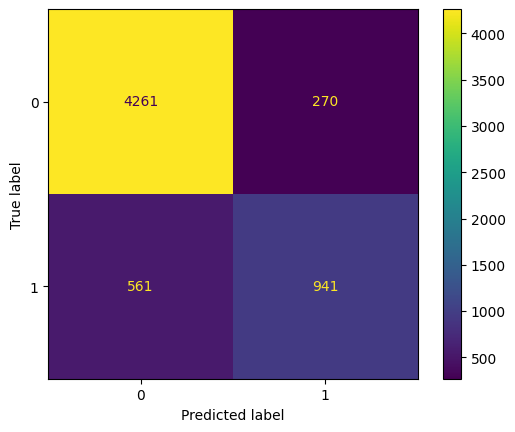

In [72]:
accuracy_real = sklearn.metrics.accuracy_score(test_labels_real, predictions_real)
print(f'Test: {accuracy_real=:.4f}')

cm = sklearn.metrics.confusion_matrix(test_labels_real, predictions_real)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot();

In [55]:
explainers_real = TabularExplainer(
    explainers=["ale", "shap_global", "lime", "mace"],                       # The explainers to apply
    mode="classification",                             # The task type
    data=train_tabular_real,                                   # The data for initializing the explainers
    model=model,                              # The ML model to explain
    preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
    params={
        "mace": {"ignored_features": ["sex_cat_private", "race"]}# params which cannot change when creating counterfactuals
    }
)

/Users/ngochoang/miniforge3/envs/omnixai/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:263: UserWarning:

Feature 5 is constant and will be replaced with 0.



In [56]:
test_instances_real = test_tabular_real[miss_but_confident]
local_explanations_real = explainers_real.explain(X=test_instances_real)
# global_explanations_real = explainers_real.explain_global()

In [57]:
print(f"There are {len(miss_but_confident)} instances where the model is very confident but wrong: {miss_but_confident}")

There are 44 instances where the model is very confident but wrong: [146, 257, 300, 638, 1040, 1103, 1317, 1378, 1409, 1426, 1481, 1528, 1640, 1847, 2142, 2344, 2351, 2407, 2530, 2671, 2742, 2903, 3022, 3023, 3247, 3388, 3579, 3868, 3963, 4020, 4065, 4112, 4116, 4379, 4425, 4698, 5012, 5079, 5137, 5260, 5261, 5549, 5633, 5704]


In [58]:
print("LIME results:")

for i, instance_id in enumerate(miss_but_confident):
    print(f"Instance {instance_id} has label {test_labels_real[instance_id]} and prediction {predictions_real[instance_id]}, with probs {model.predict_proba(test_real[instance_id:instance_id+1])[0]}")
    local_explanations_real["lime"].ipython_plot(index=i, class_names=class_names)
    if i > 10:
        break

LIME results:
Instance 146 has label 1 and prediction 0, with probs [0.95097364 0.04902636]


Instance 257 has label 1 and prediction 0, with probs [0.9626122 0.0373878]


Instance 300 has label 1 and prediction 0, with probs [0.98536755 0.01463245]


Instance 638 has label 1 and prediction 0, with probs [0.98707406 0.01292594]


Instance 1040 has label 1 and prediction 0, with probs [0.9901613 0.0098387]


Instance 1103 has label 1 and prediction 0, with probs [0.95377713 0.04622287]


Instance 1317 has label 1 and prediction 0, with probs [0.95059835 0.04940165]


Instance 1378 has label 0 and prediction 1, with probs [0.00453019 0.99546981]


Instance 1409 has label 1 and prediction 0, with probs [0.96557799 0.03442201]


Instance 1426 has label 1 and prediction 0, with probs [0.95853043 0.04146957]


Instance 1481 has label 1 and prediction 0, with probs [0.95635384 0.04364616]


Instance 1528 has label 1 and prediction 0, with probs [0.98252863 0.01747137]


In [59]:
print("MACE explanation")

for i, instance_id in enumerate(miss_but_confident):

    query_df = local_explanations_real['mace'].get_explanations()[i]['query'].reset_index(drop=True)
    query_df.index = [f"{instance_id}"] * len(query_df)


    counter_df = local_explanations_real['mace'].get_explanations()[i]['counterfactual'].reset_index(drop=True)
    counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]

    combined_df = pd.concat([query_df, counter_df])
    styled_df = combined_df.style.apply(highlight_changes, axis=1)


    display(styled_df)
    if i > 10:
        break


MACE explanation


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
146,State-gov,186634.000000,12th,8.000000,Never-married,Exec-managerial,Not-in-family,White,0.000000,0.000000,50.000000,United-States,0,0.000000,0
CF[0] for 146,State-gov,186634.000000,12th,8.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,50.000000,United-States,0,0.000000,1
CF[1] for 146,Self-emp-inc,186634.000000,12th,8.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,50.000000,United-States,0,0.000000,1
CF[2] for 146,State-gov,186634.000000,12th,8.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,50.000000,United-States,1,0.000000,1
CF[3] for 146,State-gov,186634.000000,12th,8.000000,Never-married,Exec-managerial,Not-in-family,White,0.000000,2471.000000,50.000000,United-States,0,0.000000,1
CF[4] for 146,State-gov,186792.000000,12th,8.000000,Never-married,Transport-moving,Not-in-family,White,0.000000,2471.000000,50.625000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
257,Private,100067.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,Black,0.000000,0.000000,35.000000,United-States,1,0.000000,0
CF[0] for 257,Private,100067.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,Black,5473.500000,0.000000,35.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
300,Self-emp-inc,229498.000000,Some-college,10.000000,Widowed,Sales,Not-in-family,White,0.000000,0.000000,20.000000,United-States,1,0.000000,0
CF[0] for 300,Self-emp-inc,229498.000000,Some-college,11.687500,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,38.000000,United-States,1,0.000000,1
CF[1] for 300,Self-emp-inc,229498.000000,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,25.625000,United-States,1,0.000000,1
CF[2] for 300,Self-emp-inc,229498.000000,Bachelors,10.187500,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,38.000000,United-States,1,0.000000,1
CF[3] for 300,Self-emp-inc,229498.000000,Some-college,10.000000,Widowed,Sales,Not-in-family,White,7464.750000,0.000000,20.000000,United-States,1,0.000000,1
CF[4] for 300,Self-emp-inc,229498.000000,Some-college,10.187500,Widowed,Sales,Not-in-family,White,7464.750000,0.000000,20.000000,Germany,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,0.000000,0.000000,41.000000,United-States,1,0.000000,0
CF[0] for 638,Private,137618.000000,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,41.000000,United-States,1,0.000000,1
CF[1] for 638,Private,137618.000000,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,40.937500,United-States,1,0.000000,1
CF[2] for 638,Private,138201.968750,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,41.000000,United-States,1,0.000000,1
CF[3] for 638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,7298.000000,0.000000,41.000000,United-States,1,0.000000,1
CF[4] for 638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,299.187500,2559.000000,41.437500,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1040,Private,186350.000000,HS-grad,9.000000,Widowed,Exec-managerial,Not-in-family,White,0.000000,0.000000,10.000000,United-States,1,0.000000,0
CF[0] for 1040,Private,186350.000000,HS-grad,9.562500,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,35.000000,United-States,1,0.000000,1
CF[1] for 1040,Private,190864.312500,HS-grad,9.625000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,35.000000,United-States,1,0.000000,1
CF[2] for 1040,Private,186350.000000,Some-college,9.562500,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,35.000000,United-States,1,0.000000,1
CF[3] for 1040,Private,186350.000000,HS-grad,9.000000,Widowed,Adm-clerical,Not-in-family,White,8075.625000,0.000000,10.000000,United-States,1,0.000000,1
CF[4] for 1040,Private,186350.000000,Some-college,9.000000,Widowed,Sales,Not-in-family,White,12499.875000,0.000000,10.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1103,Private,72442.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 1103,Federal-gov,72442.000000,11th,8.625000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[1] for 1103,Federal-gov,73406.968750,11th,8.625000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[2] for 1103,Federal-gov,72442.000000,11th,8.625000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,40.312500,United-States,1,0.000000,1
CF[3] for 1103,Private,145256.875000,11th,7.000000,Married-civ-spouse,Other-service,Married,White,0.000000,1902.000000,40.000000,United-States,1,0.000000,1
CF[4] for 1103,Private,73406.968750,11th,7.000000,Married-civ-spouse,Other-service,Married,White,5473.500000,0.000000,40.437500,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1317,Private,356238.000000,Assoc-acdm,12.000000,Never-married,Other-service,Not-in-family,White,0.000000,0.000000,80.000000,United-States,1,0.000000,0
CF[0] for 1317,Private,356238.000000,Assoc-acdm,13.750000,Never-married,Exec-managerial,Not-in-family,White,0.000000,0.000000,80.000000,United-States,1,0.000000,1
CF[1] for 1317,Private,356238.000000,Assoc-acdm,14.750000,Married-civ-spouse,Other-service,Not-in-family,White,0.000000,0.000000,80.000000,United-States,1,0.000000,1
CF[2] for 1317,Private,355797.187500,Assoc-acdm,13.750000,Never-married,Exec-managerial,Not-in-family,White,0.000000,0.000000,80.000000,United-States,1,0.000000,1
CF[3] for 1317,Private,356238.000000,Assoc-acdm,12.000000,Married-civ-spouse,Exec-managerial,Not-in-family,White,0.000000,0.000000,80.000000,United-States,1,0.000000,1
CF[4] for 1317,Self-emp-not-inc,355797.187500,Assoc-acdm,12.000000,Never-married,Other-service,Married,White,7621.875000,0.000000,80.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1378,Self-emp-not-inc,145574.000000,HS-grad,9.000000,Divorced,Exec-managerial,Not-in-family,White,34095.000000,0.000000,60.000000,United-States,1,0.000000,1
CF[0] for 1378,Self-emp-not-inc,145574.000000,HS-grad,9.000000,Divorced,Exec-managerial,Not-in-family,White,6392.812500,0.000000,60.000000,United-States,1,0.000000,0


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1409,State-gov,105728.000000,HS-grad,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,0.000000,0.000000,28.000000,United-States,1,0.000000,0
CF[0] for 1409,State-gov,105728.000000,HS-grad,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,6249.937500,0.000000,28.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1426,Self-emp-not-inc,128516.000000,Assoc-acdm,12.000000,Widowed,Sales,Unmarried,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 1426,Self-emp-not-inc,128516.000000,Assoc-acdm,14.750000,Widowed,Sales,Married,White,0.000000,0.000000,41.625000,United-States,1,0.000000,1
CF[1] for 1426,Self-emp-not-inc,127725.562500,Assoc-acdm,14.750000,Widowed,Sales,Married,White,0.000000,0.000000,42.000000,United-States,1,0.000000,1
CF[2] for 1426,Self-emp-not-inc,128516.000000,Assoc-acdm,12.562500,Widowed,Exec-managerial,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[3] for 1426,Private,128516.000000,Assoc-acdm,12.000000,Widowed,Sales,Unmarried,White,0.000000,2387.812500,40.000000,United-States,1,0.000000,1
CF[4] for 1426,Federal-gov,128516.000000,Assoc-acdm,12.000000,Married-civ-spouse,Exec-managerial,Unmarried,White,0.000000,1910.250000,40.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1481,Self-emp-not-inc,65738.000000,Some-college,10.000000,Married-civ-spouse,Other-service,Married,White,0.000000,0.000000,15.000000,United-States,1,0.000000,0
CF[0] for 1481,Self-emp-not-inc,28973.000000,Some-college,12.625000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,5.000000,United-States,1,0.000000,1
CF[1] for 1481,Self-emp-not-inc,65738.000000,Some-college,12.625000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,31.625000,United-States,1,0.000000,1
CF[2] for 1481,Self-emp-not-inc,65738.000000,Prof-school,12.625000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,31.625000,United-States,1,0.000000,1
CF[3] for 1481,Self-emp-not-inc,65738.000000,Some-college,10.000000,Divorced,Other-service,Married,White,4386.000000,1902.000000,15.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1528,Private,33983.000000,Assoc-voc,11.000000,Never-married,Adm-clerical,Not-in-family,White,0.000000,0.000000,42.000000,United-States,1,0.000000,0
CF[0] for 1528,Private,33983.000000,Assoc-voc,12.625000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.000000,United-States,1,0.000000,1
CF[1] for 1528,Private,33983.000000,Assoc-voc,12.625000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.500000,United-States,1,0.000000,1
CF[2] for 1528,Private,33983.000000,Bachelors,12.625000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.000000,United-States,1,0.000000,1
CF[3] for 1528,Federal-gov,127306.000000,Prof-school,11.000000,Never-married,Adm-clerical,Not-in-family,White,0.000000,1564.000000,50.000000,United-States,1,0.000000,1
CF[4] for 1528,Federal-gov,39815.687500,Assoc-voc,11.000000,Never-married,Adm-clerical,Not-in-family,White,7298.000000,123.562500,42.000000,United-States,1,0.000000,1


In [60]:
for i, instance_id in enumerate(miss_but_confident):
    print('\nPRIVATE DATA:')
    print(f'Instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]} with prob {model.predict_proba(test[instance_id:instance_id+1])[0]}')
    print('ORIGINAL DATA:')
    print(f'Instance {instance_id} has label {test_labels_real[instance_id]} and prediction {predictions_real[instance_id]} with prob {model.predict_proba(test_real[instance_id:instance_id+1])[0]}')


PRIVATE DATA:
Instance 146 has label 1 and prediction 0 with prob [0.95097364 0.04902636]
ORIGINAL DATA:
Instance 146 has label 1 and prediction 0 with prob [0.95097364 0.04902636]

PRIVATE DATA:
Instance 257 has label 1 and prediction 0 with prob [0.9626122 0.0373878]
ORIGINAL DATA:
Instance 257 has label 1 and prediction 0 with prob [0.9626122 0.0373878]

PRIVATE DATA:
Instance 300 has label 1 and prediction 0 with prob [0.98099815 0.01900185]
ORIGINAL DATA:
Instance 300 has label 1 and prediction 0 with prob [0.98536755 0.01463245]

PRIVATE DATA:
Instance 638 has label 1 and prediction 0 with prob [0.98738149 0.01261851]
ORIGINAL DATA:
Instance 638 has label 1 and prediction 0 with prob [0.98707406 0.01292594]

PRIVATE DATA:
Instance 1040 has label 1 and prediction 0 with prob [0.9901613 0.0098387]
ORIGINAL DATA:
Instance 1040 has label 1 and prediction 0 with prob [0.9901613 0.0098387]

PRIVATE DATA:
Instance 1103 has label 1 and prediction 0 with prob [0.95377713 0.04622287]
ORIG

In [83]:
private_probs = []
private_labels = []
real_probs = []
real_labels = []
real_real = []
for i, instance_id in enumerate(miss_but_confident):
    priv = model.predict_proba(test[instance_id:instance_id+1])[0]
    private_probs.append(max(priv))
    private_labels.append(predictions[instance_id])
    real = model.predict_proba(test_real[instance_id:instance_id+1])[0]
    real_probs.append(max(real))
    real_labels.append(predictions_real[instance_id])
    real_real.append(test_labels_real[instance_id])

prob_change = pd.DataFrame(list(zip(miss_but_confident, private_labels, private_probs, real_labels, real_probs, real_real)),
                           columns=['Instance ID', 'Preds on private set',
                                    'Probs on private set', 'Preds on real set', 'Probs on real set', 'Actual labels'])
prob_change['Private values'] = prob_change.apply(lambda x: f'age={test_tabular.data.iloc[int(x["Instance ID"])]["age_cat_private"]}, sex={df_private.iloc[int(x["Instance ID"])]["sex_cat_private"]}', axis=1)
prob_change['Real values'] = prob_change.apply(lambda x: f'age={test_tabular_real.data.iloc[int(x["Instance ID"])]["age_cat_private"]}, sex={df.iloc[int(x["Instance ID"])]["sex_cat_private"]}', axis=1)
prob_change['delta'] = prob_change['Probs on real set'] - prob_change['Probs on private set']
prob_change

,Instance ID,Preds on private set,Probs on private set,Preds on real set,Probs on real set,Actual labels,Private values,Real values,delta
0,146,0,0.950974,0,0.950974,1,"age=0, sex=0","age=0, sex=0",0.000000
1,257,0,0.962612,0,0.962612,1,"age=1, sex=0","age=1, sex=0",0.000000
2,300,0,0.980998,0,0.985368,1,"age=0, sex=0","age=1, sex=0",0.004369
3,638,0,0.987381,0,0.987074,1,"age=0, sex=0","age=1, sex=0",-0.000307
4,1040,0,0.990161,0,0.990161,1,"age=1, sex=1","age=1, sex=0",0.000000
5,1103,0,0.953777,0,0.953777,1,"age=1, sex=1","age=1, sex=0",0.000000
6,1317,0,0.960916,0,0.950598,1,"age=0, sex=0","age=1, sex=0",-0.010318
7,1378,1,0.995470,1,0.995470,0,"age=1, sex=0","age=1, sex=0",0.000000
8,1409,0,0.965578,0,0.965578,1,"age=1, sex=0","age=1, sex=0",0.000000
9,1426,0,0.961467,0,0.958530,1,"age=0, sex=1","age=1, sex=0",-0.002936


In [84]:
prob_change['delta'].describe()

count    44.000000
mean     -0.000625
std       0.002469
min      -0.010637
25%      -0.000711
50%       0.000000
75%       0.000000
max       0.004369
Name: delta, dtype: float64

In [85]:
most_change = prob_change[prob_change['delta'] == prob_change['delta'].min()]
most_change_id = most_change['Instance ID'].values[0]
print(most_change_id)
most_change

5260


,Instance ID,Preds on private set,Probs on private set,Preds on real set,Probs on real set,Actual labels,Private values,Real values,delta
39,5260,1,0.958774,1,0.948137,0,"age=1, sex=1","age=1, sex=0",-0.010637


Let us investigate data point where there was the biggest change in confidence between the private dataset and the real dataset.

In [86]:
print(f'In the private dataset, the privatized age and sex values are:')
print(test_tabular.data.iloc[most_change_id]['age_cat_private'], test_tabular.data.iloc[most_change_id]['sex_cat_private'])
print(f'In the original dataset, the un-privatized age and sex values are:')
print(test_tabular_real.data.iloc[most_change_id]['age_cat_private'], test_tabular.data.iloc[most_change_id]['sex_cat_private'])

In the private dataset, the privatized age and sex values are:
1 1.0
In the original dataset, the un-privatized age and sex values are:
1 1.0


In [87]:
ins_id = most_change_id
features_dict = dict()
for i, instance_id in enumerate(miss_but_confident):
    if instance_id == ins_id:
        print(f'LIME result of instance ID {ins_id} on the private dataset:')
        local_explanations["lime"].ipython_plot(index=i, class_names=class_names)
        explanation = local_explanations["lime"].get_explanations()[i]
        for (feature, value, score) in zip(explanation['features'], explanation['values'], explanation['scores']):
            print(feature, value, score)
        print(f'\nLIME result of instance ID {ins_id} on the real dataset:')
        local_explanations_real["lime"].ipython_plot(index=i, class_names=class_names)
        explanation_real = local_explanations_real["lime"].get_explanations()[i]
        for (feature, value, score) in zip(explanation_real['features'], explanation_real['values'], explanation_real['scores']):
            print(feature, value, score)

LIME result of instance ID 5260 on the private dataset:


capital_gain 0.0 -0.707281595120642
education_num 14.0 0.1732623538583963
marital_status Married-civ-spouse 0.1281099354703629
relationship Married 0.1047975310369308
hours_per_week 55.0 0.09410071825796743
capital_loss 1902.0 0.052207495145553805
occupation Prof-specialty 0.04044826149625902
race White 0.029926513046348326
age_cat_private 1 0.009456921571872608
native_country United-States 0.008079549881505409

LIME result of instance ID 5260 on the real dataset:


capital_gain 0.0 -0.6877559385450047
education_num 14.0 0.1787397461965022
marital_status Married-civ-spouse 0.1244056879672787
relationship Married 0.10382571197676652
capital_loss 1902.0 0.09738470008988923
hours_per_week 55.0 0.09697244787364306
occupation Prof-specialty 0.04154486131613838
race White 0.020097843543378346
native_country United-States 0.017926808156950715
workclass Local-gov 0.011090313853153027


In [92]:
points = []
for i in range(predictions.shape[0]):
    if predictions[i] != predictions_real[i]:
        points.append(i)

print(len(points))
print(points)

25
[739, 888, 1244, 1325, 1560, 1761, 2193, 2490, 2564, 2598, 2677, 3034, 3244, 3468, 3782, 3812, 4234, 4307, 4541, 4641, 4776, 4966, 5682, 5792, 5971]


In [103]:
pairs = []
for point in points:
    priv_point = test_tabular.data.iloc[point:point+1]
    priv_point['pred'] = predictions[point]
    priv_point['prob_0'] = model.predict_proba(test[point:point+1])[0][0]
    priv_point['prob_1'] = model.predict_proba(test[point:point+1])[0][1]

    real_point = test_tabular_real.data.iloc[point:point+1]
    real_point['pred'] = predictions_real[point]
    real_point['prob_0'] = model.predict_proba(test_real[point:point+1])[0][0]
    real_point['prob_1'] = model.predict_proba(test_real[point:point+1])[0][1]

    pair = pd.concat([priv_point, real_point])
    actual_label = [test_labels[point], test_labels_real[point]]
    pair['true_label'] = actual_label
    pairs.append(pair)

change_df = pd.concat(pairs)

/var/folders/2l/srpzk4jx3bd_85xnzblspysc0000gn/T/ipykernel_7858/2107161446.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2l/srpzk4jx3bd_85xnzblspysc0000gn/T/ipykernel_7858/2107161446.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2l/srpzk4jx3bd_85xnzblspysc0000gn/T/ipykernel_7858/2107161446.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [105]:
cols = ['age_cat_private', 'sex_cat_private', 'pred', 'prob_0', 'prob_1', 'true_label']
change_df[cols]

,age_cat_private,sex_cat_private,pred,prob_0,prob_1,true_label
739,0,1.0,0,0.504902,0.495098,1
739,1,0.0,1,0.425846,0.574154,1
888,0,0.0,0,0.519332,0.480668,0
888,1,0.0,1,0.492794,0.507206,0
1244,0,0.0,1,0.495741,0.504259,0
1244,1,0.0,0,0.501124,0.498876,0
1325,0,0.0,1,0.472264,0.527736,0
1325,1,0.0,0,0.578866,0.421134,0
1560,0,0.0,0,0.503866,0.496134,1
1560,1,0.0,1,0.487658,0.512342,1
